In [94]:
from utils import *
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import scipy
import numpy as np
import cupy as cp
import pandas as pd
import math
import json
from PIL import Image, ImageDraw
from collections import defaultdict
import itertools
from hdv import *
from sklearn.model_selection import train_test_split

In [95]:
config = Config()
IMAGE_SIZE = config.sample_size

device_marker = np.empty(1)
xp = cp.get_array_module(device_marker)

RNG = xp.random.default_rng()

In [96]:
%%time
IMAGES_ALL = []
IMAGES_METADATA = []

with open(os.path.join(config.dataset_path, config.dataset_metadata_file_name)) as f:
    metadata = json.load(f)

for image_fname in tqdm(os.listdir(config.dataset_path)):
    image_fname = os.path.join(config.dataset_path, image_fname)

    if not image_fname.endswith('.png'):
        continue

    # Following fuss with "with" is required to prevent "Too many open files" problem
    with Image.open(image_fname) as image:
        image.load()
        assert image.width == image.height
        assert image.width == IMAGE_SIZE
        assert image.mode == 'L'
        image_index = len(IMAGES_ALL)
        IMAGES_ALL.append(np.array(image).ravel())
        metadata_record = metadata[os.path.basename(image_fname)]
        metadata_record = np.rec.array([(image_fname, metadata_record.get('value', '?'))], dtype=[('file_name', 'object'), ('value', 'object')])
        IMAGES_METADATA.append(metadata_record)
        
    assert image.fp is None

assert len(IMAGES_ALL) == len(IMAGES_METADATA)
IMAGES_ALL = np.array(IMAGES_ALL)
IMAGES_METADATA = np.rec.array(np.concatenate(IMAGES_METADATA))
print(f'Loaded {len(IMAGES_ALL)} images')

  0%|          | 0/10001 [00:00<?, ?it/s]

Loaded 10000 images
CPU times: user 1.24 s, sys: 116 ms, total: 1.36 s
Wall time: 1.35 s


In [97]:
images_train_indices, images_test_indices = train_test_split(range(len(IMAGES_ALL)))
IMAGES_TRAIN = IMAGES_ALL[images_train_indices]
IMAGES_METADATA_TRAIN = IMAGES_METADATA[images_train_indices]
IMAGES_TEST = IMAGES_ALL[images_test_indices]
IMAGES_METADATA_TEST = IMAGES_METADATA[images_test_indices]

del IMAGES_ALL
del IMAGES_METADATA

IMAGES_TRAIN.shape, IMAGES_TEST.shape

((7500, 16384), (2500, 16384))

In [98]:
def matrix_to_image(m):
    return Image.frombytes('L', size=(IMAGE_SIZE, IMAGE_SIZE), data=m.reshape(IMAGE_SIZE, IMAGE_SIZE).astype(xp.uint8))


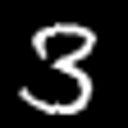
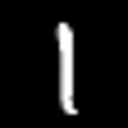
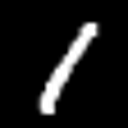
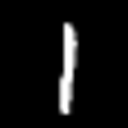
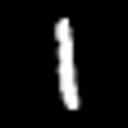
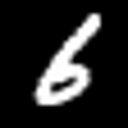
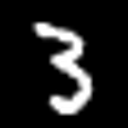
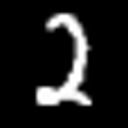
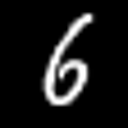
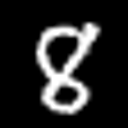
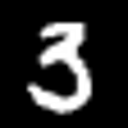
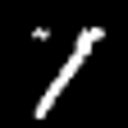
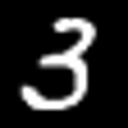
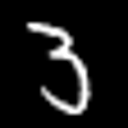
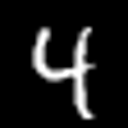
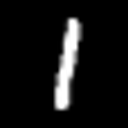

In [99]:
count = 8

def get_some_random_images_and_labels(images, images_metadata, count):
    indices = RNG.integers(len(images), size=(count,))
    labels = list(images_metadata[indices]['value'])
    images = list(map(lambda i: matrix_to_image(images[i]), indices))
    return images, labels

train_images, train_labels = get_some_random_images_and_labels(IMAGES_TRAIN, IMAGES_METADATA_TRAIN, count)
test_images, test_labels = get_some_random_images_and_labels(IMAGES_TEST, IMAGES_METADATA_TEST, count)

display_images_grid(train_images + test_images, captions=train_labels + test_labels, col_count=count)

In [100]:
SENSOR_RECEPTIVE_FIELD_SIZE = 8
SENSOR_RECEPTIVE_FIELD_SQUARE = SENSOR_RECEPTIVE_FIELD_SIZE * SENSOR_RECEPTIVE_FIELD_SIZE
SENSOR_GROUP_SIZE = 4
SENSOR_GROUP_SQUARE = SENSOR_GROUP_SIZE * SENSOR_GROUP_SIZE
RETINA_SIZE = 16
RETINA_SQUARE = RETINA_SIZE * RETINA_SIZE


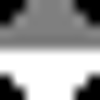
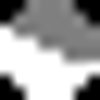
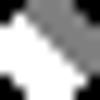
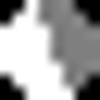
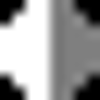
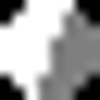
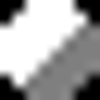
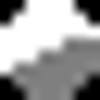
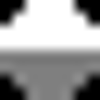
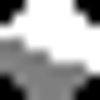
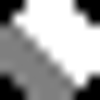
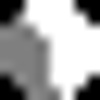
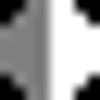
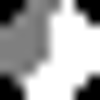
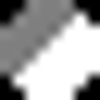
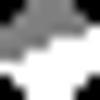

In [101]:
group_sensors_img = []
captions = []
steps = pow(SENSOR_GROUP_SIZE, 2)
sz = RETINA_SIZE * SENSOR_RECEPTIVE_FIELD_SIZE

for i in range(steps):
    canvas = Image.new('L', (sz, sz))
    draw = ImageDraw.Draw(canvas)
    draw.ellipse([0, 0, SENSOR_RECEPTIVE_FIELD_SIZE - 1, SENSOR_RECEPTIVE_FIELD_SIZE - 1], outline=0, fill=127, width=0)
    angle = i * 360 / steps
    draw.chord([0, 0, SENSOR_RECEPTIVE_FIELD_SIZE - 1, SENSOR_RECEPTIVE_FIELD_SIZE - 1], angle, angle + 180, outline=255, fill=255)
    group_sensors_img.append(canvas)
    captions.append(f'#{i} ({i // SENSOR_GROUP_SIZE}, {i % SENSOR_GROUP_SIZE})')

display_images_grid(list(map(lambda x: x.crop([0,0,SENSOR_RECEPTIVE_FIELD_SIZE,SENSOR_RECEPTIVE_FIELD_SIZE]).resize((100, 100)), group_sensors_img)), col_count=SENSOR_GROUP_SIZE, captions=captions)

In [102]:
group_sensors = xp.array(list(map(xp.array, group_sensors_img))).astype(float)
shape_save = group_sensors.shape
group_sensors = group_sensors.reshape(SENSOR_GROUP_SIZE*SENSOR_GROUP_SIZE, -1)
# Due to rough granularity count of positive pixels and negative may be not eqaul => equalize via weight
group_sensors[group_sensors==255] = 1
counts_of_positives = (group_sensors == 1).sum(axis=1)
counts_of_negatives = (group_sensors == 127).sum(axis=1)
white_image = xp.ones(group_sensors.shape[1])

for i, (p, n) in enumerate(zip(counts_of_positives, counts_of_negatives)):
    assert p > 0, (i, p)
    assert n > 0, (i, n)
    group_sensors[i][group_sensors[i] == 127] = -1 * (p / n)
    v = group_sensors[i] @ white_image
    assert xp.isclose(v, 0), v

group_sensors = group_sensors.reshape(shape_save)
group_sensors.shape, np.unique_counts(group_sensors)

((16, 128, 128),
 UniqueCountsResult(values=array([-1.36363636, -1.26086957, -1.16666667, -1.08      , -1.        ,
         0.        ,  1.        ]), counts=array([    44,    138,     48,     50,    104, 261312,    448])))

In [103]:
group_sensors_ones = (group_sensors.reshape(group_sensors.shape[0], -1) == 1).sum(axis=1)
group_sensors_ones, group_sensors_ones.mean(), group_sensors_ones.min(), group_sensors_ones.max(), group_sensors_ones.std()

(array([26, 27, 29, 28, 26, 28, 29, 27, 26, 29, 29, 30, 26, 30, 29, 29]),
 np.float64(28.0),
 np.int64(26),
 np.int64(30),
 np.float64(1.4142135623730951))


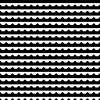
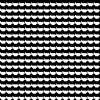
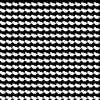
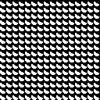
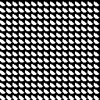
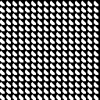
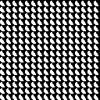
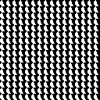
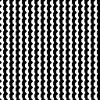
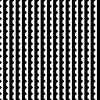
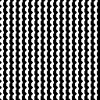
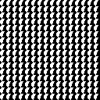
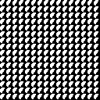
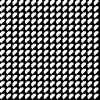
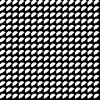
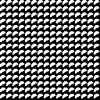
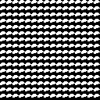
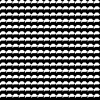
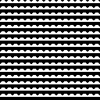
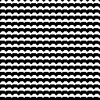
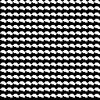
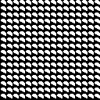
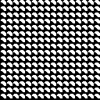
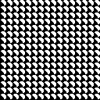
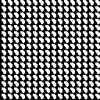
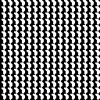
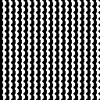
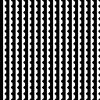
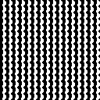
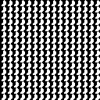
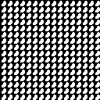
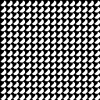
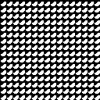
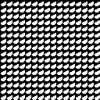
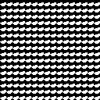
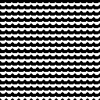

In [109]:
sz = RETINA_SIZE * SENSOR_RECEPTIVE_FIELD_SIZE
steps = 36 # 10 degreee
specific_samples_img = []
captions = []

for i in range(steps):
    canvas = Image.new('L', (sz, sz))
    draw = ImageDraw.Draw(canvas)
    angle = i * 360 / steps
       
    draw.chord([0, 0, SENSOR_RECEPTIVE_FIELD_SIZE - 1, SENSOR_RECEPTIVE_FIELD_SIZE - 1], angle, angle + 180, outline=255, fill=255)
    crop = canvas.crop([0, 0, SENSOR_RECEPTIVE_FIELD_SIZE, SENSOR_RECEPTIVE_FIELD_SIZE])

    for x in range(0, sz, SENSOR_RECEPTIVE_FIELD_SIZE):
        for y in range(0, sz, SENSOR_RECEPTIVE_FIELD_SIZE):
            canvas.paste(crop, [x, y, x + SENSOR_RECEPTIVE_FIELD_SIZE, y + SENSOR_RECEPTIVE_FIELD_SIZE])
            
    specific_samples_img.append(canvas)
    captions.append(f'#{i}')

display_images_grid(list(map(lambda x: x.resize((100, 100)), specific_samples_img)), col_count=int(np.sqrt(steps)), captions=captions)

In [110]:
SPECIFIC_SAMPLES = xp.array(list(map(xp.array, specific_samples_img))).astype(float)
SPECIFIC_SAMPLES[SPECIFIC_SAMPLES==255] = 1
SPECIFIC_SAMPLES = SPECIFIC_SAMPLES.reshape(SPECIFIC_SAMPLES.shape[0], -1)
SPECIFIC_SAMPLES.shape, np.unique_counts(SPECIFIC_SAMPLES)

((36, 16384),
 UniqueCountsResult(values=array([0., 1.]), counts=array([331776, 258048])))

In [111]:
# single sensor occupies (RETINA_SIZE * SENSOR_RECEPTIVE_FIELD_SIZE) ^ 2
# we have group of such sensors stacked under each other in a square fashion, hence SENSOR_GROUP_SIZE^2
# to cover all visual area we have RETINA_SIZE^2 of such groups
retina = xp.zeros((RETINA_SIZE, RETINA_SIZE, pow(SENSOR_GROUP_SIZE, 2), pow(RETINA_SIZE * SENSOR_RECEPTIVE_FIELD_SIZE, 2)))
retina = retina.reshape((RETINA_SIZE, RETINA_SIZE, pow(SENSOR_GROUP_SIZE, 2), -1))

for y in range(RETINA_SIZE):
    for x in range(RETINA_SIZE):
        for g in range(pow(SENSOR_GROUP_SIZE, 2)):
            sensor_at_place = group_sensors[g]
            sensor_at_place = np.roll(sensor_at_place, y * SENSOR_RECEPTIVE_FIELD_SIZE, axis=0)
            sensor_at_place = np.roll(sensor_at_place, x * SENSOR_RECEPTIVE_FIELD_SIZE, axis=1)
            retina[y, x, g, :] = sensor_at_place.reshape(-1)

retina = retina.reshape((-1, pow(RETINA_SIZE * SENSOR_RECEPTIVE_FIELD_SIZE, 2)))
RETINA_POS = retina
RETINA_NEG = retina.copy()

RETINA_POS[RETINA_POS < 0] = 0
RETINA_NEG[RETINA_NEG > 0] = 0

In [112]:
def lay_grid(image, step):
    draw = ImageDraw.Draw(image)

    for c in range(step - 1, image.height, step):
        draw.line([0, c, image.width, c], fill=127)
        draw.line([c, 0, c, image.height], fill=127)

    return image

In [113]:
MINIMAL_ILLUMINATION_ABS_LEVEL = 255 * 0.1
MINIMAL_ILLUMINATION_DIFF_DB = 2 # dB
MINIMAL_ILLUMINATION_DIFF_RATIO = pow(10, MINIMAL_ILLUMINATION_DIFF_DB/20)

def sense_images(images, active_sensors=None):
    active_sensors = xp.ones((RETINA_SQUARE * SENSOR_GROUP_SQUARE, 1)) if active_sensors is None else active_sensors
    assert active_sensors.shape == (RETINA_POS.shape[0], 1)
    sense_ress = []
    image_masks = images.copy()
    image_masks[image_masks > 0] = 1

    effective_retina_pos = RETINA_POS * active_sensors
    effective_retina_neg = RETINA_NEG * active_sensors
    sense_area = (effective_retina_pos @ image_masks.T).T # for check of illuminated area
    sense_level = (effective_retina_pos @ images.T).T # for check of absolute illumination
    sense_neg_level = (effective_retina_neg @ images.T).T # for check of relative diff

    assert sense_area.shape == (len(images), RETINA_SQUARE * SENSOR_GROUP_SQUARE), sense_area.shape
    assert sense_area.shape == sense_level.shape
    assert sense_area.shape == sense_neg_level.shape
    
    # Base for calculations = AREA of illumination must be at least 1/2 of area of positive receptors
    # Next we exclude sensors which do not minimal LEVEL of illumination = area * (255 * 10%)
    # Finally we exclude sensors which do not have enough contrast (DIFF) - use NEG part of retina and use logarithmic scale (dB)
    for sense_area_i, sense_level_i, sense_neg_level_i in zip(sense_area, sense_level, sense_neg_level):
        sense_area_i = sense_area_i.reshape(-1, 16)
        cond1 = (sense_area_i / group_sensors_ones) >= 0.5 # At least half of a positive area of each of sensors is activated
        cond1 = cond1.reshape(-1,)
    
        sense_level_i = sense_level_i.reshape(-1, 16)
        sense_level_i[sense_level_i <= 0] = 1e-6 # to ease cond3
        cond2 = (sense_level_i > MINIMAL_ILLUMINATION_ABS_LEVEL * group_sensors_ones) # Illumination level of an area must exceed given threshold
        cond2 = cond2.reshape(-1,)
    
        sense_neg_level_i = xp.abs(sense_neg_level_i)
        sense_neg_level_i[sense_neg_level_i <= 0] = 1e-6 # to ease cond3
        cond3 = (sense_level_i.reshape(-1,) / sense_neg_level_i) >= MINIMAL_ILLUMINATION_DIFF_RATIO # Illumination of positive area must be > illumination of negative one
    
        sense_res = (cond1 & cond2 & cond3).astype(int) # mask of active sensors for particular image
        sense_ress.append(sense_res)

    return xp.array(sense_ress)

In [114]:
def get_uniform_drifts():
    drifts = []
    drift_range = range(-4, 6, 2)
    
    for i in drift_range:
        for j in drift_range:
            drifts.append((i,j))   
    
    return drifts

In [115]:
def get_image_drifts(image, drifts):
    images = []

    for drift in drifts:
        image_drifted = image.reshape(IMAGE_SIZE, IMAGE_SIZE)
        image_drifted = np.roll(image_drifted, drift[0], axis=0)
        rows_to_wipeout = [min(drift[0], 0) + i for i in range(abs(drift[0]))]
        image_drifted[rows_to_wipeout,:] = 0
        image_drifted = np.roll(image_drifted, drift[1], axis=1)
        cols_to_wipeout = [min(drift[1], 0) + i for i in range(abs(drift[1]))]
        image_drifted[:,cols_to_wipeout] = 0
        image_drifted = image_drifted.reshape(-1)
        images.append(image_drifted)

    return xp.array(images)

In [116]:
COS_SIM_THRESHOLD = 0.075
hdv = Hdv(10_000, xp)

In [121]:
def generate_permutation_matrix(input_vector_dims):
    pm = xp.zeros((input_vector_dims, input_vector_dims), dtype='b')
    row_indices = RNG.choice(pm.shape[0], pm.shape[0], replace=False)
    
    for row_index, column_index in zip(row_indices, range(pm.shape[1])):
        pm[row_index, column_index] = 1

    return pm

In [132]:
pm = generate_permutation_matrix(100)
assert xp.array_equal((pm == 1).sum(axis=0), xp.ones(pm.shape[0]))
assert xp.array_equal((pm == 1).sum(axis=1), xp.ones(pm.shape[0]))
rand_vec = RNG.integers(0, 2, pm.shape[0])
mutated_rand_vec = pm @ rand_vec
assert xp.array_equal(pm.T @ mutated_rand_vec, rand_vec)
assert xp.array_equal(xp.unique_counts(rand_vec).counts, xp.unique_counts(mutated_rand_vec).counts)

In [269]:
class CorticalColumn(object):
    def __init__(self, input_vector_dims, stride_width, strides_count):
        #self.input_vector_permutation2 = generate_permutation_matrix(input_vector_dims)
        self.stride_width = stride_width
        self.stride_hdvs = defaultdict(hdv)

        assert input_vector_dims >= stride_width
        total_strides = input_vector_dims // stride_width
        assert strides_count <= total_strides
        self.stride_indices = RNG.choice(total_strides, strides_count, replace=False)
        self.stride_indices *= stride_width
        assert xp.all(xp.unique_counts(self.stride_indices).counts == 1)
        
        self.stage_norm_hdvs = []
        self.conso_norm_hdvs = xp.zeros(shape=(0, hdv.N))
        self.stage_norm_hdv_index_to_image_index = dict()
        self.conso_norm_hdv_index_to_image_index = dict()

    def remember(self, norm_hdv, image_index):
        assert image_index > -1
        assert norm_hdv.shape == (hdv.N,)
        self.stage_norm_hdvs.append(norm_hdv)
        norm_hdv_index = len(self.stage_norm_hdvs) - 1
        assert norm_hdv_index > -1
        self.stage_norm_hdv_index_to_image_index[norm_hdv_index] = image_index

In [286]:
CORTICAL_COLUMNS_COUNT = 30
CORTICAL_COLUMNS = []
CORTICAL_COLUMNS_PMS = xp.zeros((CORTICAL_COLUMNS_COUNT, image_encoding_dims, image_encoding_dims))
image_encoding_dims = RETINA_SQUARE * SENSOR_GROUP_SQUARE

for i in range(CORTICAL_COLUMNS_COUNT):
    if i % 5 == 0:
        column = CorticalColumn(image_encoding_dims, SENSOR_GROUP_SQUARE, RETINA_SQUARE)
    else:
        column = CorticalColumn(image_encoding_dims, SENSOR_GROUP_SQUARE, RETINA_SQUARE // 8)
    
    CORTICAL_COLUMNS.append(column)
    #CORTICAL_COLUMNS_PMS[i] = column.input_vector_permutation2
    CORTICAL_COLUMNS_PMS[i] = generate_permutation_matrix(image_encoding_dims)


assert len(CORTICAL_COLUMNS) == CORTICAL_COLUMNS_COUNT

In [272]:
ma = np.arange(2 * 4 * 4).reshape((2, 4, 4))
v = np.ones(4)
ma @ v

array([[  6.,  22.,  38.,  54.],
       [ 70.,  86., 102., 118.]])

In [273]:
ma

array([[[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11],
        [12, 13, 14, 15]],

       [[16, 17, 18, 19],
        [20, 21, 22, 23],
        [24, 25, 26, 27],
        [28, 29, 30, 31]]])

In [274]:
ma.shape

(2, 4, 4)

In [287]:
count = 1000
image_encodings = sense_images(IMAGES_TRAIN[:count]) # shape: image, image encoding for an image. E.g. (count, 4096)

for image_index, image_encoding in tqdm(enumerate(image_encodings), total=count):
    image_encoding_for_columns = CORTICAL_COLUMNS_PMS @ image_encoding
    
    # Ощупываем image с разных сторон, аггресивно запоминаем всё подряд
    for column_index, (column, image_encoding_for_column) in enumerate(zip(CORTICAL_COLUMNS, image_encoding_for_columns)):
        #image_encoding_for_column = column.input_vector_permutation @ image_encoding
        column_norm_hdv = []
    
        for stride_index in column.stride_indices:
            stride = image_encoding_for_column[stride_index:stride_index + column.stride_width]

            if xp.all(stride == 0):
                continue
                
            stride_code = ''.join(map(str, stride.tolist()))
            stride_hdv = column.stride_hdvs[stride_code]
            stride_hdv = hdv.shift(stride_hdv, stride_index)
            column_norm_hdv.append(stride_hdv)

        if column_norm_hdv:
            column_norm_hdv = hdv.bundle_noties(column_norm_hdv)
            column_norm_hdv = hdv.normalize(column_norm_hdv)
            column.remember(column_norm_hdv, image_index)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [288]:
# Consolidate memory
for column in CORTICAL_COLUMNS:
    if column.stage_norm_hdvs:
        offset = column.conso_norm_hdvs.shape[0]
        offsetted_mapping = map(lambda p: (p[0] + offset, p[1]), column.stage_norm_hdv_index_to_image_index.items())
        column.conso_norm_hdvs = xp.append(column.conso_norm_hdvs, column.stage_norm_hdvs, axis=0)
        column.conso_norm_hdv_index_to_image_index.update(offsetted_mapping)

    column.stage_norm_hdvs = []
    column.stage_norm_hdv_index_to_image_index = dict()

In [289]:
def get_consensus_table(image_encoding):
    table = defaultdict(list)
    image_encoding_for_columns = CORTICAL_COLUMNS_PMS @ image_encoding
    
    for column_index, (column, image_encoding_for_column) in enumerate(zip(CORTICAL_COLUMNS, image_encoding_for_columns)):
        column_norm_hdv = []
    
        for stride_index in column.stride_indices:
            stride = image_encoding_for_column[stride_index:stride_index + column.stride_width]

            if xp.all(stride == 0):
                continue

            stride_code = ''.join(map(str, stride.tolist()))
            stride_hdv = column.stride_hdvs[stride_code]
            stride_hdv = hdv.shift(stride_hdv, stride_index)
            column_norm_hdv.append(stride_hdv)

        if not column_norm_hdv:
            continue
            
        column_norm_hdv = hdv.bundle_noties(column_norm_hdv)
        column_norm_hdv = hdv.normalize(column_norm_hdv)
    
        cos_sims = column.conso_norm_hdvs @ column_norm_hdv # this will compute cos sim against all HDVs
        candidate_hdv_indices = xp.argwhere(cos_sims >= COS_SIM_THRESHOLD).reshape(-1)

        for candidate_hdv_index in candidate_hdv_indices:
            cos_sim = cos_sims[candidate_hdv_index]
            candidate_image_index = column.conso_norm_hdv_index_to_image_index[candidate_hdv_index]
            table['column_index'].append(column_index)
            table['image_index'].append(candidate_image_index)
            table['sim'].append(cos_sim)

    return table

In [314]:
%%time
count = 50
images_row = []
image_protos_rows = [[], [], []]
images_captions = []
image_protos_captions = [[], [], []]
inference_table = []

def get_image_safe(images_dataset, index):
    if index < 0:
        return Image.new('L', size=(1,1), color=255)
        
    return matrix_to_image(images_dataset[index])

test_image_indices = RNG.choice(len(IMAGES_TEST), count, replace=False)
    
for image_index in tqdm(test_image_indices):
    image = IMAGES_TEST[image_index]
    images_row.append(image_index)
    true_value = IMAGES_METADATA_TEST[image_index]['value']
    images_captions.append(f'#{image_index}, val={true_value}')
    inference_record = [image_index, int(true_value)]
    
    drifts = RNG.normal(0, 5, size=(10, 2)).astype(int)
    image_variants = get_image_drifts(image, drifts)
    image_variant_encodings = sense_images(image_variants)

    for image_variant_encoding in image_variant_encodings:
        consensus_table = get_consensus_table(image_variant_encoding)

        if len(consensus_table) == 0:
            continue

        consensus_table = pd.DataFrame(consensus_table, columns=['column_index', 'image_index', 'sim'])
        assert len(consensus_table) > 0
        image_protos = pd.pivot_table(consensus_table, 
                                      index=['image_index'], 
                                      values=['sim', 'column_index'], 
                                      aggfunc={'sim': 'sum', 'column_index': 'nunique'},
                                      sort=False)
        image_protos = image_protos[(image_protos[('column_index')] >= len(CORTICAL_COLUMNS) * 0.75)]
        image_protos.sort_values(by=['column_index', 'sim'], ascending=[False, False], inplace=True)

        if len(image_protos) > 0:
            break
    else:
        image_protos = pd.DataFrame(columns=['dummy'])

    for row, captions, image_proto in itertools.zip_longest(image_protos_rows, image_protos_captions, image_protos.iterrows()):
        if row is None:
            break
            
        image_proto_index, votes, cos_sim = (-1, 0, 0) if image_proto is None else (int(image_proto[0]), int(image_proto[1]['column_index']), image_proto[1]['sim'])
        row.append(image_proto_index)
        inferred_value = int(IMAGES_METADATA_TRAIN[image_proto_index]['value']) if image_proto_index >= 0 else -1
        captions.append(f'#{image_proto_index}, votes={votes}, sim={cos_sim:.2f}, val={inferred_value}')

        if len(inference_record) < 3:
            inference_record.append(inferred_value)

    inference_table.append(inference_record)

test_images = list(map(lambda i: get_image_safe(IMAGES_TEST, i), images_row))
train_images = list(map(lambda i: get_image_safe(IMAGES_TRAIN, i), itertools.chain.from_iterable(image_protos_rows)))
df = pd.DataFrame(inference_table, columns=['test_image_index', 'true value', 'infer. value'])
df['is_match'] = df['true value'] == df['infer. value']
print(f'ACCURACY = {df['is_match'].sum() / len(df) * 100:.2f}% (matched {df['is_match'].sum()} of {len(df)})')
df

  0%|          | 0/50 [00:00<?, ?it/s]

ACCURACY = 80.00% (matched 40 of 50)
CPU times: user 43min 7s, sys: 8.33 s, total: 43min 15s
Wall time: 3min 45s


,test_image_index,true value,infer. value,is_match
0,497,5,-1,False
1,1147,6,6,True
2,2310,8,8,True
3,683,3,3,True
4,694,4,4,True
5,2461,5,3,False
6,32,9,7,False
7,1676,6,6,True
8,759,1,1,True
9,1330,8,3,False



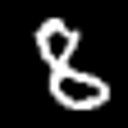
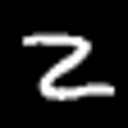
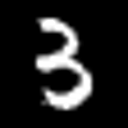
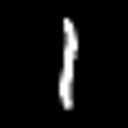
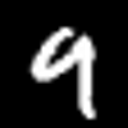
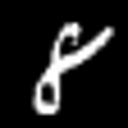
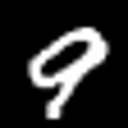
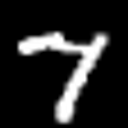
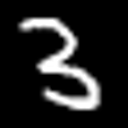
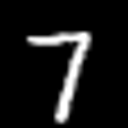
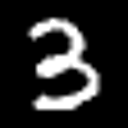
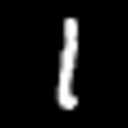
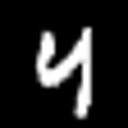
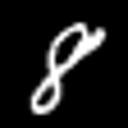
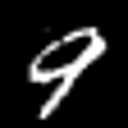
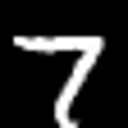
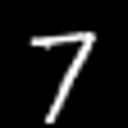
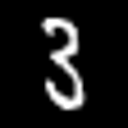
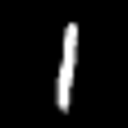
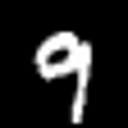
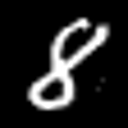
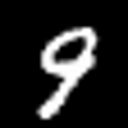
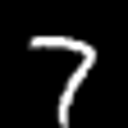
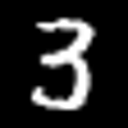
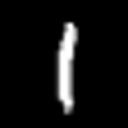
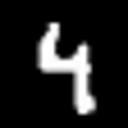
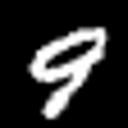
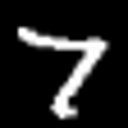

In [313]:
display_images_grid(test_images+train_images,
                    col_count=count, 
                    captions=images_captions + list(itertools.chain.from_iterable(image_protos_captions)))

In [182]:
consensus_table

defaultdict(list,
            {'column_index': [0],
             'image_index': [24],
             'sim': [np.float64(1.000000000000008)]})